# NTF and Robust-NTF on Corrupted Synthetic Data

Here, we generate a synthetic low-rank 3-dimensional tensor from known signals. We insert nonlinear outliers (1% and 19% of the overall dataset) and observe the performance of classic non-negative tensor factorization against the proposed robust variant.

## Setup

In [1]:
import torch
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
import sys
from torch.nn.functional import normalize
from scipy import signal
from scipy.stats import gamma
from tensorly.kruskal_tensor import kruskal_to_tensor
from tensorly.decomposition.candecomp_parafac import non_negative_parafac
from tensorly.tenalg.outer_product import outer

sys.path.append("..")
from robust_ntf.robust_ntf import RntfConfig, RobustNTF, RntfStats

# Use the GPU at fp64 by default:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

# Make TensorLy use PyTorch:
tl.set_backend('pytorch')

# Set RNG seeds:
torch.manual_seed(33)
np.random.seed(33)

# Set an epsilon to protect against zeros:
eps = 1e-6

## Part 1: Generate synthetic tensor

### Generate ground truth factors:

Over here, we generate ground truth factor matrices to generate a rank-3 synthetic tensor with. They include,

* A Gaussian modulated sinusoid and take its real and imaginary parts, and its envelope to be the ground truth factors.
* Three different chirp signals.
* Three different Gamma PDFs.

In [2]:
#######################
## Mode-1 generation ##
#######################

# Sample 50 points:
mode1_support = np.linspace(-1, 1, 2*25, endpoint=False)

# Generate signal and plot:
x1, x2, x3 = signal.gausspulse(mode1_support, fc=3,
                               retquad=True, retenv=True)
x1 = 2 * np.abs(x1)
x2 = 2 * np.abs(x2)
x3 = 2 * np.abs(x3)

#######################
## Mode-2 generation ##
#######################

mode2_support = np.linspace(-1, 1, 96, endpoint=False)
y1 = signal.chirp(mode2_support, f0=4, t1=-0.5, f1=4)
y2 = signal.chirp(mode2_support, f0=2, t1=0.5, f1=3)
y3 = signal.chirp(mode2_support, f0=1, t1=0.1, f1=2)

y1 = y1 - y1.min()
y2 = y2 - y2.min()
y3 = y3 - y3.min()

#######################
## Mode-3 generation ##
#######################

mode3_support = np.linspace(0, 10, 20)

z1 = gamma(7).pdf(mode3_support)
z2 = gamma(2).pdf(mode3_support)
z3 = gamma(4).pdf(mode3_support)

### Plot ground truth factors:

Text(0.5, 1.0, 'Mode-3 factors')

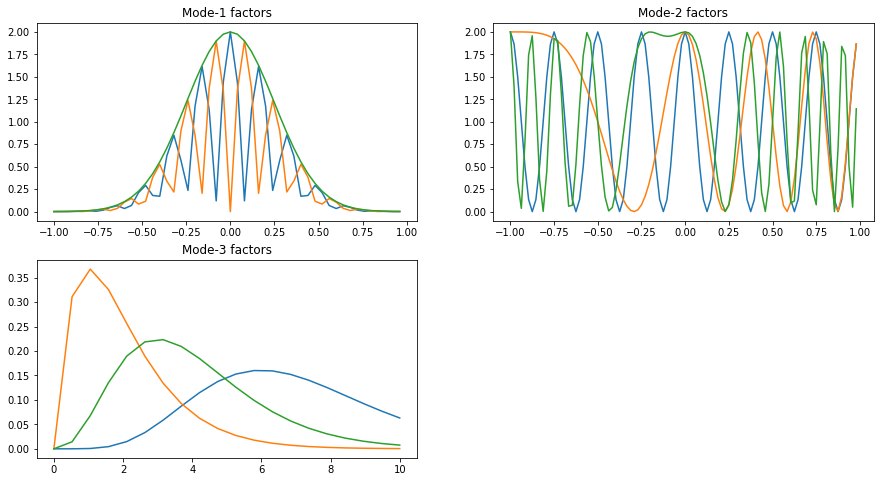

In [3]:
# Set up figure size:
fig = plt.figure(figsize=(15,8))

# Plot factors:
plt.subplot(2,2,1)
plt.plot(mode1_support, x1,
         mode1_support, x2,
         mode1_support, x3)
plt.gca().set_title('Mode-1 factors')

plt.subplot(2,2,2)
plt.plot(mode2_support, y1,
         mode2_support, y2,
         mode2_support, y3)
plt.gca().set_title('Mode-2 factors')

plt.subplot(2,2,3)
plt.plot(mode3_support, z1,
         mode3_support, z2,
         mode3_support, z3)
plt.gca().set_title('Mode-3 factors')

### Cast factors to PyTorch and/or make positive:

In [4]:
# Mode-1:
X = np.array([x1, x2, x3])
X = torch.from_numpy(X).cuda() + eps

# Mode-2:
Y = np.array([y1, y2, y3])
Y = torch.from_numpy(Y).cuda() + eps

# Mode-3:
Z = np.array([z1, z2, z3])
Z = torch.from_numpy(Z).cuda() + eps

### Construct ground truth tensor to factorize:

In [5]:
# Construct Kruskal tensor in TensorLy format:
ktens = (None, [X.t(), Y.t(), Z.t()])

# Construct dense tensor:
data = kruskal_to_tensor(ktens)

In [6]:
for i in range(data.shape[-1]):
    data[-int(2.5*i)-1:, :, i+1:] = np.nan
np.isnan(data.cpu().numpy()).sum() / data.cpu().numpy().size

0.442

### Visualize some frontal slices of the tensor in false color:

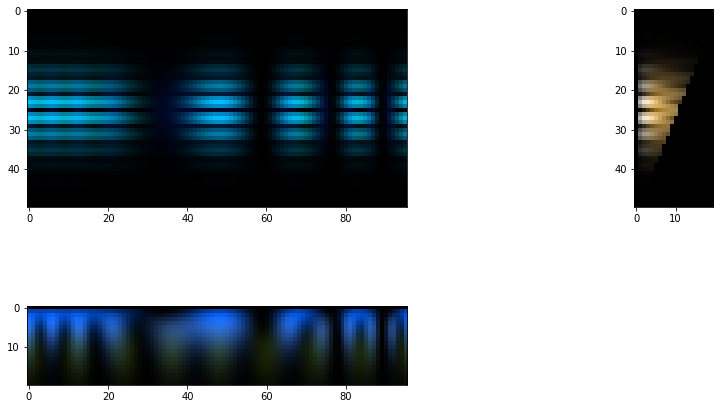

In [7]:
fig = plt.figure(figsize=(15,8))

# XY
plt.subplot(2,2,1)
XY = data[:, :, 0:3].data.cpu().numpy()
XY = XY / np.nanmax(XY)
plt.imshow(XY)

# XZ
plt.subplot(2,2,2)
XZ = data[:, 0:3, :].data.cpu().numpy()
XZ = XZ.transpose([0, 2, 1])
XZ = XZ / np.nanmax(XZ)
plt.imshow(XZ)

# ZY
plt.subplot(2,2,3)
ZY = data[0:3, :, :].data.cpu().numpy()
ZY = ZY.transpose([2, 1, 0])
ZY = ZY / np.nanmax(ZY)
plt.imshow(ZY)

### Add ~1% outliers to data:
We use the sigmoid function as an off-the-shelf nonlinearity, applied to individual **fibers** within the tensor. 

In [8]:
data_01 = data.clone()

m1_mask_01 = np.random.randint(0, 50, 5)
m2_mask_01 = np.random.randint(0, 96, 10)
m3_mask_01 = np.random.randint(0, 20, 5)

for i in m1_mask_01:
    for j in m2_mask_01:
        data_01[i, j, :] = torch.sigmoid(data[i, j, :])

for j in m2_mask_01:
    for k in m3_mask_01:
        data_01[:, j, k] = torch.sigmoid(data[:, j, k])

for i in m1_mask_01:
    for k in m3_mask_01:
        data_01[i, :, k] = torch.sigmoid(data[i, :, k])

## Part 2: Compare methods

### Perform NTF and rNTF on synthetic data with 1% outliers:

In [9]:
# Perform robust-NTF:
max_iter = 200000
step = 100
save_points = list(range(max_iter, step))

cfg = RntfConfig(3, 2, 0.1, 1e-15, max_iter=200000, print_every=100, save_every=1000, save_folder="./out")
rntf = RobustNTF(cfg)
rntf.run(data_01)
rntf_01_factors = rntf.matrices
rntf_01_outlier = rntf.outlier
vals = rntf.stats

Initializing rNTF with uniform noise.


AttributeError: 'RntfData' object has no attribute 'compute_L2_accuracy'

In [ ]:
fig = plt.figure(figsize=(8,15))

inds = list(range(len(vals["error"])))
x_end = np.log10(inds[-1]) - 0.02

plt.subplot(4,1,1)
obj = vals[RntfStats.OBJ].to_numpy()
plt.plot(np.log10(inds[0:]), np.log10(obj[0:]))
plt.annotate("Objective", xy=(x_end, np.log10(obj[-1])+0.1), horizontalalignment="right")
fit = vals[RntfStats.FIT].to_numpy()
plt.plot(np.log10(inds[0:]), np.log10(fit[0:]), linestyle="dashed", color="gray")
plt.annotate("Fitness (Beta Divergence)", xy=(x_end, np.log10(fit[-1])+0.1), horizontalalignment="right")
reg = vals[RntfStats.REG].to_numpy()
plt.plot(np.log10(inds[0:]), np.log10(reg[0:]), linestyle=":", color="gray")
plt.annotate("Regularization Term ($L_{2,1}$ Norm)", xy=(x_end, np.log10(reg[-1])-0.08), horizontalalignment="right", verticalalignment="top")
plt.title("Objective Function")

plt.subplot(4,1,2)
err = vals[RntfStats.ERR].to_numpy()
plt.plot(np.log10(inds[0:]), np.log10(err[0:]))
plt.title("Relative Change in Objective Function (Error)")

plt.subplot(4,1,3)
L2_acc = vals[RntfStats.L2_ACC].to_numpy()
plt.plot(np.log10(inds[0:]), np.log10(L2_acc[0:]))
plt.title("Accuracy ($L_{2}$ Norm)")

plt.subplot(4,1,4)
Linf_acc = vals[RntfStats.LINF_ACC].to_numpy()
plt.plot(np.log10(inds[0:]), np.log10(Linf_acc[0:]))
plt.title("Accuracy ($L_{inf}$ Norm)")

fig.tight_layout()

### Plot results for 1% outliers:
Here, mode-3 factors for NTF and rNTF are plotted. With 1% outliers, NTF components are degraded, whereas rNTF is relatively stable.

Similar results are observed for mode-1 and mode-2.

In [ ]:
# Set up figure size:
fig = plt.figure(figsize=(15,5))

plt.plot(normalize(rntf_01_factors[2], dim=0).data.cpu().numpy())
plt.gca().set_title('robust-NTF Mode-3 results')

## Visualize reconstructions: Data, NTF, and rNTF

rNTF is visually closer to the original dataset than NTF, but has noticeable artefacts.

In [ ]:
# Reconstruct rNTF factors:
rntf_recon = torch.zeros(50,96,20)

for i in range(3):
    rntf_recon = rntf_recon + outer([rntf_01_factors[0][:,i],
                                     rntf_01_factors[1][:,i],
                                     rntf_01_factors[2][:,i]])

## Plot results:
# Set up figure size:
fig = plt.figure(figsize=(10, 15))

# Plot original data:
plt.subplot(3,1,1)
plt.imshow(data[:, 0, :].data.cpu().numpy())
plt.gca().set_title('Original data slices')
# Plot rNTF reconstruction:
plt.subplot(3,1,2)
plt.imshow(rntf_recon[:, 0, :].data.cpu().numpy())
plt.gca().set_title('Robust-NTF reconstruction slices')

In [ ]:
# Outliers
#ntf_recon = kruskal_to_tensor(ntf_19)

## Plot results:
# Set up figure size:
fig = plt.figure(figsize=(10, 15))

# Plot original data:
plt.subplot(3,1,1)
plt.imshow(data[:, 0, :].data.cpu().numpy())
plt.gca().set_title('Original data slices')

# Plot rNTF reconstruction:
plt.subplot(3,1,2)
plt.imshow(rntf_01_outlier[:, 0, :].data.cpu().numpy())
plt.gca().set_title('Robust-NTF outlier slices')

out = np.nanmax(rntf_01_outlier[:, 0, :].cpu().numpy()) / np.nanmax(data[:, 0, :].cpu().numpy())
print("Outlier max / data max: {:.1%}".format(out.item()))

np.nanmax(data[:, :, :].cpu().numpy())
np.nanmin(data[:, :, :].cpu().numpy())